## Projekt zespołowy na przedmiot Statystyczna analiza danych
### Autorzy: Machnik, Bury, Żerdziński
### Wydział Matematyki Stosowanej, III rok, V semestr

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa import seasonal
from IPython.display import display, Math, Latex
from sklearn.model_selection import train_test_split

## Zbiór danych składa się z następujących kolumn:

Time: Znacznik czasowy zdarzenia trzęsienia ziemi.

Latitude: Współrzędna geograficzna określająca pozycję północ-południe.

Longitude: Współrzędna geograficzna określająca pozycję wschód-zachód.

Depth: Głębokość trzęsienia ziemi w kilometrach.

Mag: Magnituda trzęsienia ziemi.

MagType: Typ pomiaru magnitudy.

Nst: Liczba stacji sejsmicznych, które zgłosiły trzęsienie ziemi.

Gap: Różnica między zasięgiem różnych stacji sejsmicznych.

Dmin: Minimalna odległość do epicentrum trzęsienia ziemi dla najbliższej stacji.

Rms: Pierwiastek średniokwadratowy widma amplitudy trzęsienia ziemi.

Net: Sieć raportująca trzęsienie ziemi.

Id: Unikalny identyfikator zdarzenia trzęsienia ziemi.

Updated: Znacznik czasowy wskazujący, kiedy informacje o trzęsieniu ziemi były ostatnio zaktualizowane.

Place: Opis lokalizacji trzęsienia ziemi.

Type: Rodzaj zjawiska sejsmicznego (np. trzęsienie ziemi).

HorizontalError: Błąd położenia poziomego.

DepthError: Błąd w określaniu głębokości.

MagError: Błąd w określaniu magnitudy.

MagNst: Liczba stacji sejsmicznych używanych do obliczenia magnitudy.

Status: Status zdarzenia trzęsienia ziemi (np. zrecenzowane).

LocationSource: Źródło raportujące lokalizację trzęsienia ziemi.

MagSource: Źródło raportujące magnitudę trzęsienia ziemi.

## Spis Treści:
### Baza danych
- wgranie danych i wstępne zapoznanie się z nimi
- podstawowe statystyki danych
- analiza przypadków odstających, wpływ eliminacji przypadków odstających na podstawowe statystyki
- wykres ramka-wąsy
- kategoryzacja danych
- skośności
### Testy parametryczne i nieparametryczne
- test istotności różnic między grupami (założenia)
- test istotności różnic między zmiennym
- testy normalności rozkładu
- przedział ufności dla średniej
- ANOVA
- Pozostałe testy, które znajdzieszs u Kempy UZUPEŁNIĆ
### Korelacja i regresja
- wyznaczanie i analiza współczynników korelacji Pearsona i Spearmana
- test istotności współczynnika korelacji
- regresja liniowa, budowa i weryfikacja
### Analiza szeregów czasowych
- przygotowanie danych
- trend szeregu czasowego
- autokorelacja szeregu
- analiza Fouriera szeregu czasowego
- współczynniki sezonowości

## Wgranie danych i wstępne zapoznanie się z nimi
Dalszej analizie poddamy zmienne znajdujące się w kolumnach 'depth', 'mag', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError'

In [212]:
COLUMNS_TO_ANALYZE = ['depth', 'mag', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError']
COLORS = ["blue", "orange", "green", "red", "blue", "orange", "green", "red"]
dataset = pd.read_csv("earthquakes_2023_global.csv")
df = dataset[COLUMNS_TO_ANALYZE].copy()
df.head()

,depth,mag,dmin,rms,horizontalError,depthError,magError
0,82.770,3.10,0.8700,0.18,8.46,21.213,0.097
1,79.194,4.50,1.1520,0.47,5.51,7.445,0.083
2,24.000,3.93,0.8479,0.22,0.91,15.950,0.090
3,63.787,4.30,0.4570,0.51,10.25,6.579,0.238
4,10.000,3.00,0.4000,0.31,1.41,1.999,0.085


## Sprawdzenie brakujących wartości
Nie wszystkie rekordy zawierają pełne dany. A więc usuwamy te, które ich nie zawierają.

In [213]:
print(df.isnull().sum())
df = df.dropna()

depth                 0
mag                   0
dmin               1866
rms                   0
horizontalError    1549
depthError            0
magError           1672
dtype: int64


## Wyświetlenie statystyk opisowych dla każdej z kolumnm. 
Później zanalizujemy przypadki odstające i sprawdzimy, czy po ich usunięciu wynik się znacząco zmienił.
25% (Q1 - kwartyl pierwszy): To pierwszy kwartyl, który reprezentuje wartość, poniżej której znajduje się 25% danych. Innymi słowy, 25% danych ma wartości mniejsze lub równe temu kwartylowi.

50% (Q2 - mediana): To mediana, która reprezentuje wartość, poniżej której znajduje się 50% danych. Mediana jest środkową wartością w posortowanym zbiorze danych.

75% (Q3 - kwartyl trzeci): To trzeci kwartyl, który reprezentuje wartość, poniżej której znajduje się 75% danych. Innymi słowy, 75% danych ma wartości mniejsze lub równe temu kwartylowi.

max: To maksymalna wartość w danej kolumnie, reprezentująca największą wartość w zestawie danych.

In [214]:
df.describe()

,depth,mag,dmin,rms,horizontalError,depthError,magError
count,24396.000000,24396.000000,24396.000000,24396.000000,24396.000000,24396.000000,24396.000000
mean,69.814514,4.088480,2.726237,0.587716,7.165696,4.763273,0.118483
std,120.901715,0.761686,4.065195,0.253543,4.005881,4.459825,0.057254
min,-3.370000,2.600000,0.000000,0.010000,0.000000,0.100000,0.000000
25%,10.000000,3.500000,0.632000,0.420000,4.350000,1.880000,0.080000
50%,21.553000,4.300000,1.607000,0.590000,7.180000,2.723000,0.109000
75%,67.305500,4.500000,3.200250,0.750000,9.810000,6.924000,0.148000
max,681.238000,7.800000,50.820000,1.880000,99.000000,60.670000,0.770000


## Analiza przypadków odstających, wpływ eliminacji przypadków odstających na podstawowe statystyki
Analizę rozpoczniemy od stworzenia histogramów, aby zapoznać się z rozkładami zmiennych, które poddaliśmy analizie

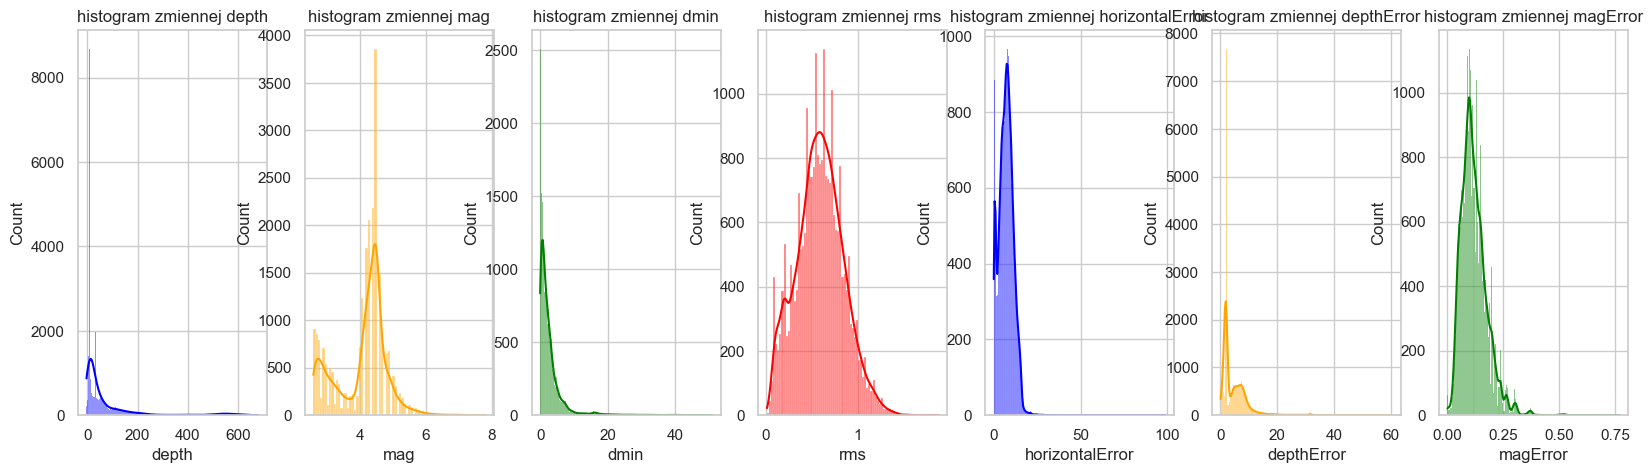

In [215]:
fig, axs = plt.subplots(1, len(COLUMNS_TO_ANALYZE), figsize=(20, 5))
for i in range(len(COLUMNS_TO_ANALYZE)):
    sns.histplot(df[COLUMNS_TO_ANALYZE[i]], kde=True, ax=axs[i], color=COLORS[i]).set(title=f"histogram zmiennej {COLUMNS_TO_ANALYZE[i]}")
plt.show()

Wstępna analiza pokazuje nam, że raczej nie są to rozkłady normalne. Dla pewności przeprowadzimy test Shapiro-Wilka.

Hipoteza zerowa: Próbka należy do rozkładu normalnego

Hipoteza alternatywna: Próbka nie należy do rozkładu normalnego.

In [216]:
def check_null_hypothesis(p):
    return f"Odrzucamy zerową hipotezę ponieważ (p=={p}) < 0.05" if p < 0.05 else f"Przyjmujemy zerową hipotezę ponieważ (p=={p}) > 0.05"
for col in COLUMNS_TO_ANALYZE:
    print(f"Dla {col}: ", end="")
    test_stats = stats.shapiro(df[col])
    print(check_null_hypothesis(test_stats.pvalue))
    print(f"moc testu: {test_stats.statistic}")

Dla depth: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.5501800775527954
Dla mag: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.9154384136199951
Dla dmin: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.5684837102890015
Dla rms: Odrzucamy zerową hipotezę ponieważ (p==1.969423940664271e-31) < 0.05
moc testu: 0.9933888912200928
Dla horizontalError: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.9673941135406494
Dla depthError: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.749376654624939
Dla magError: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.9371459484100342


C:\Users\Jakub\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Jak widzimy, wartość p dla każdego testu jest mniejsza niż 0.05, więc każdy test odrzucamy i przyjmujemy hipotezę alternatywną. Z tego wynika, że żadna z próbka nie posiada rozkładu normalnego.

## Wykres ramka-wąsy dla analizowanych zmiennych
Wąsy: reprezentują minimalną i maksymalną wartość danych, które nie są uważane za odstające. Wartości odstające, znajdujące się poza wąsami, mogą być potencjalnie nietypowe.

Pudełko: wyznacza obszar między dolnym a górnym kwartylem danych. Dolny kwartyl (Q1) to 25% danych, a górny kwartyl (Q3) to 75% danych. Wartość środkowa pudełka to mediana, która dzieli dane na dwie równe części.

Linia środkowa: teprezentuje medianę danych, co oznacza, że 50% danych jest poniżej tej wartości.

Punkty odstające: pojedyncze punkty lub wartości, które znajdują się poza wąsami i mogą sugerować nietypowe lub skrajne wartości w danych.

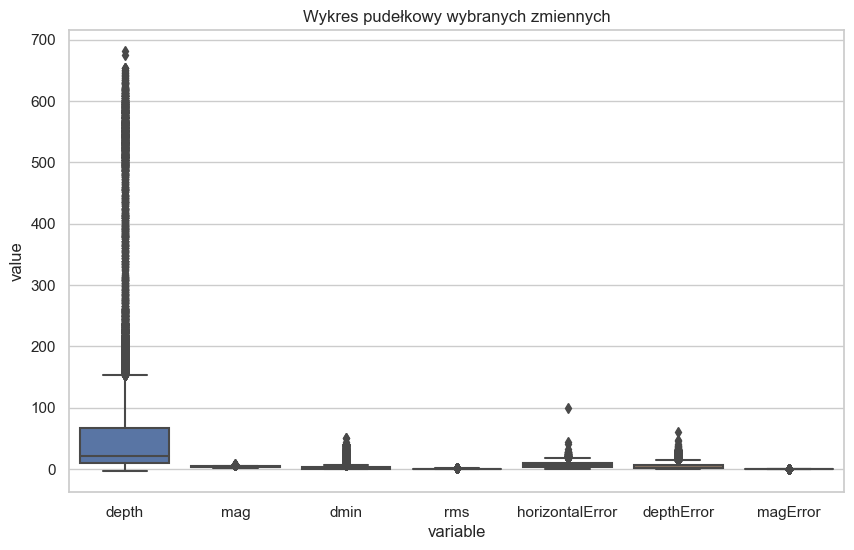

In [217]:
df_long = pd.melt(df)
plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', data=df_long).set(title="Wykres pudełkowy wybranych zmiennych")
plt.show()

### Jak widzimy, możemy się spodziewać dużej liczby wartości odstających, na pewno w przypadku głębokości. Zatem postarajmy się wyczyścić te dane z tych wartości.
Rozstawu międzykwartylowy używamy, ponieważ jest to najlepsza miara zmienności dla rozkładów skośnych oraz dla danych z wartościami odstającymi. Jako, że jest oparta na medianie, mało prawdopodobne jest by miałby na niego wpływ wartości skrajne.
Skala logiczna informuje o zmianach względnych (multiplikatywnych), natomiast liniowa o zmianach bezwzględnych (addytywnych). Gdy zależy nam na zmianach względnych, używamy skali logarytmicznej; gdy zależy nam na zmianach bezwzględnych, używamy skali liniowej. Nam zależy na zmianach względnych, dlatego używam skali logarytmicznej.

In [218]:
df = np.log(df)

# Obliczenie kwantyli
quantiles = df.quantile([0.25, 0.75])

# Usunięcie danych odstających
for col in df.columns:
    iqr = stats.iqr(df[col], nan_policy="omit")
    lower_bound = quantiles.iloc[0][col] - iqr * 1.5
    upper_bound = quantiles.iloc[1][col] + iqr * 1.5

    # Zastąp wartości odstające granicami zakresu
    df.loc[df[col] < lower_bound, col] = lower_bound
    df.loc[df[col] > upper_bound, col] = upper_bound

df = df[df['depth'] >= -10]
df = df[df['dmin'] >= -10]
df = df[df['horizontalError'] >= -5]
df = df[df['magError'] >= -5]
# Po usunięciu
total_data_points_after = df.size
total_outliers_after = total_data_points_after - df.count().sum()
percentage_removed_after = (total_outliers_after / total_data_points_after) * 100

print(f"Po usunięciu: Usunięto {percentage_removed_after:.2f}% danych odstających.")

Po usunięciu: Usunięto 0.00% danych odstających.


C:\Users\Jakub\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\Jakub\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


### Dane po usunięciu wartości odstających

In [219]:
print(df.describe().T)

                   count      mean       std       min       25%       50%  \
depth            24370.0  3.318550  1.306852 -0.560222  2.302585  3.075075   
mag              24370.0  1.389286  0.200597  0.955511  1.252763  1.458615   
dmin             24370.0  0.253672  1.362339 -2.892008 -0.456298  0.474991   
rms              24370.0 -0.629655  0.487203 -1.737228 -0.867501 -0.527633   
horizontalError  24370.0  1.784877  0.696108  0.250336  1.472472  1.971299   
depthError       24370.0  1.194227  0.884854 -1.324311  0.631272  1.007958   
magError         24370.0 -2.245371  0.486646 -3.448507 -2.525729 -2.216407   

                      75%       max  
depth            4.211123  6.523912  
mag              1.504077  1.881049  
dmin             1.164322  3.596371  
rms             -0.287682  0.582046  
horizontalError  2.283402  3.503242  
depthError       1.935391  3.890576  
magError        -1.910543 -0.987765  


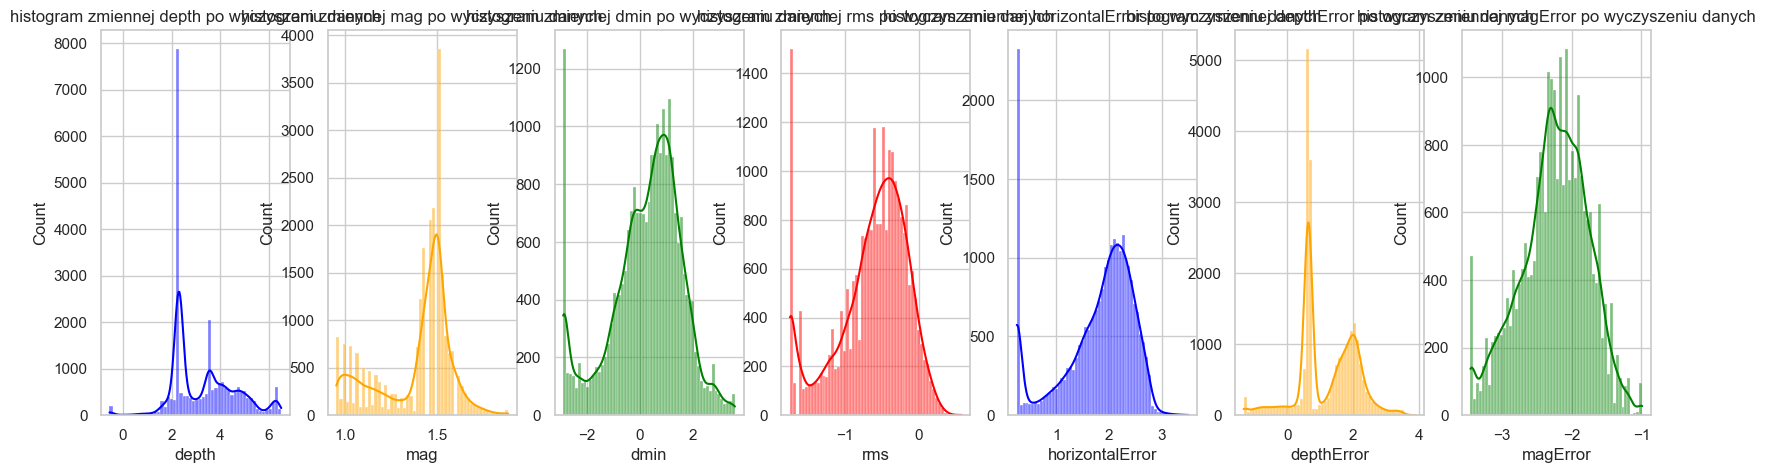

In [220]:
fig, axs = plt.subplots(1, len(COLUMNS_TO_ANALYZE), figsize=(20, 5))
for i in range(len(COLUMNS_TO_ANALYZE)):
    sns.histplot(df[COLUMNS_TO_ANALYZE[i]], kde=True, ax=axs[i], color=COLORS[i]).set(title=f"histogram zmiennej {COLUMNS_TO_ANALYZE[i]} po wyczyszeniu danych")
plt.show()

In [221]:
df = df.dropna()
for col in df.columns:
    print(f"Dla {col}: ", end="")
    test_stats = stats.shapiro(df[col])
    print(check_null_hypothesis(test_stats.pvalue))
    print(f"moc testu: {test_stats.statistic}")

Dla depth: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.9224838018417358
Dla mag: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.8798681497573853
Dla dmin: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.9617801904678345
Dla rms: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.9366053342819214
Dla horizontalError: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.8966546654701233
Dla depthError: Odrzucamy zerową hipotezę ponieważ (p==0.0) < 0.05
moc testu: 0.944204568862915
Dla magError: Odrzucamy zerową hipotezę ponieważ (p==5.92088398053622e-39) < 0.05
moc testu: 0.9889653325080872


C:\Users\Jakub\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### W dalszym ciągu, żaden z rozkładów nie jest normalny.

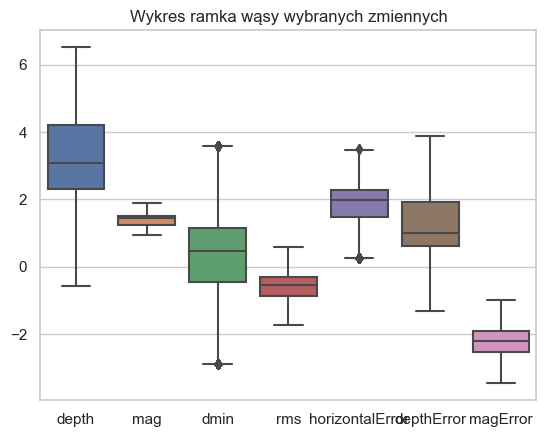

In [222]:
sns.boxplot(df).set(title="Wykres ramka wąsy wybranych zmiennych")
plt.show()


## Kategoryzacja danych
Stworzymy szeregi rozdzielcze, które będę posiadały po 5 przedziałów.

In [223]:
df_categories = pd.DataFrame()
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df_categories[col + '_category'] = pd.qcut(df[col], q=5, duplicates='drop')

# Wyświetlenie wyników
print(df_categories)

        depth_category    mag_category     dmin_category      rms_category  \
0       (3.555, 4.523]  (0.955, 1.163]   (-0.732, 0.114]  (-1.738, -0.994]   
1       (3.555, 4.523]  (1.482, 1.526]    (0.114, 0.755]  (-0.994, -0.654]   
2       (2.303, 3.555]  (1.163, 1.435]   (-0.732, 0.114]  (-1.738, -0.994]   
3       (3.555, 4.523]  (1.435, 1.482]  (-2.893, -0.732]  (-0.994, -0.654]   
4      (-0.561, 2.303]  (0.955, 1.163]  (-2.893, -0.732]  (-1.738, -0.994]   
...                ...             ...               ...               ...   
26637  (-0.561, 2.303]  (1.526, 1.881]    (1.317, 3.596]   (-0.223, 0.582]   
26638  (-0.561, 2.303]  (1.526, 1.881]    (0.114, 0.755]  (-0.431, -0.223]   
26639  (-0.561, 2.303]  (1.526, 1.881]    (1.317, 3.596]  (-0.654, -0.431]   
26640   (4.523, 6.524]  (1.526, 1.881]    (1.317, 3.596]   (-0.223, 0.582]   
26641  (-0.561, 2.303]  (1.526, 1.881]    (1.317, 3.596]  (-0.431, -0.223]   

      horizontalError_category depthError_category  \
0        

In [224]:
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        print(f"Przedziały dla {col}:")
        categories = pd.cut(df[col], bins=5)
        
        counts = categories.value_counts()
        
        for category, count in counts.items():
            print(f"{category}: {count} przypadków")
        
        print("\n")

Przedziały dla depth:
(2.273, 3.69]: 13408 przypadków
(3.69, 5.107]: 6077 przypadków
(5.107, 6.524]: 2549 przypadków
(0.857, 2.273]: 2011 przypadków
(-0.567, 0.857]: 325 przypadków


Przedziały dla mag:
(1.326, 1.511]: 12307 przypadków
(1.511, 1.696]: 4892 przypadków
(0.955, 1.141]: 4544 przypadków
(1.141, 1.326]: 2112 przypadków
(1.696, 1.881]: 515 przypadków


Przedziały dla dmin:
(-0.297, 1.001]: 9709 przypadków
(1.001, 2.299]: 6632 przypadków
(-1.594, -0.297]: 4372 przypadków
(-2.898, -1.594]: 2694 przypadków
(2.299, 3.596]: 963 przypadków


Przedziały dla rms:
(-0.81, -0.346]: 9775 przypadków
(-0.346, 0.118]: 7179 przypadków
(-1.273, -0.81]: 3905 przypadków
(-1.74, -1.273]: 2975 przypadków
(0.118, 0.582]: 536 przypadków


Przedziały dla horizontalError:
(1.551, 2.202]: 9825 przypadków
(2.202, 2.853]: 7585 przypadków
(0.901, 1.551]: 3522 przypadków
(0.247, 0.901]: 3310 przypadków
(2.853, 3.503]: 128 przypadków


Przedziały dla depthError:
(-0.281, 0.762]: 10575 przypadków
(1.805, 2

## Skośność
Skośność w rozkładzie prawdopodobieństwa oznacza, że jego kształt nie jest symetryczny. Jeśli rozkład jest prawostronnie skośny, to znaczy, że jego górny ogon jest dłuższy, a wartości odchylają się bardziej w prawo od środka rozkładu. To oznacza, że największa koncentracja wartości znajduje się po lewej stronie wykresu, a wartości odstające są bardziej skoncentrowane po prawej stronie. Natomiast w przypadku skośności lewostronnej, wykres jest odwrotny - koncentracja jest bardziej na prawo, a wartości odstające są bardziej na lewo od środka rozkładu. W sytuacji idealnie symetrycznego rozkładu, wartości koncentrują się równo po obu stronach środka, bez wyraźnej dominacji w lewo czy w prawo.

In [225]:
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        skewness = df[col].skew()
        print(f"Skośność dla {col}: {skewness}")

Skośność dla depth: 0.4292729994911364
Skośność dla mag: -0.7980850672379394
Skośność dla dmin: -0.5630444483965573
Skośność dla rms: -0.762018006128018
Skośność dla horizontalError: -0.9411045015567489
Skośność dla depthError: -0.2026504492783965
Skośność dla magError: -0.30482065658990964


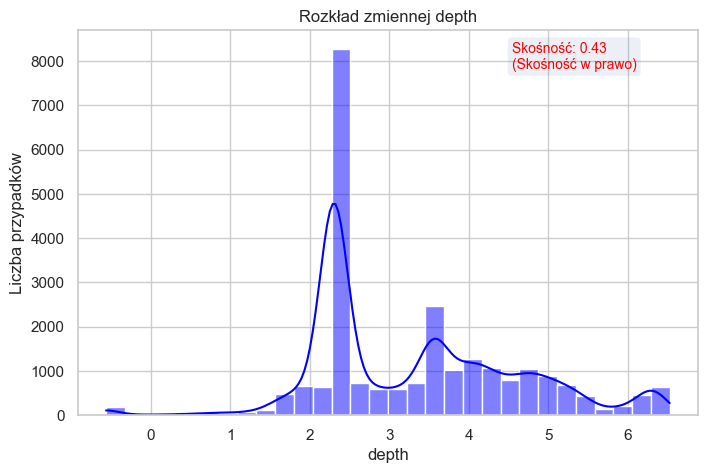

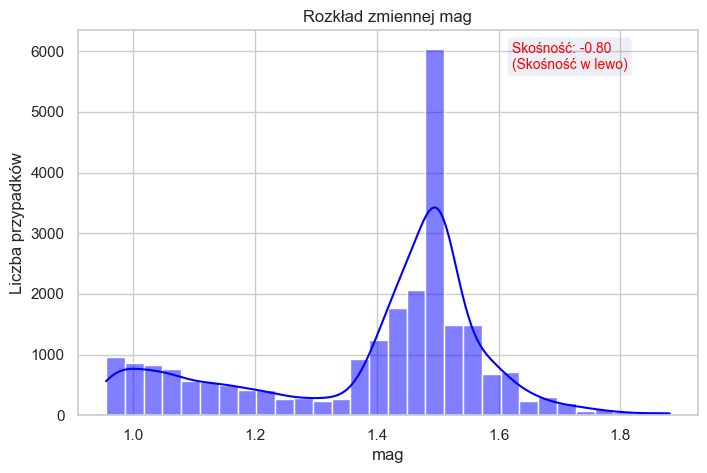

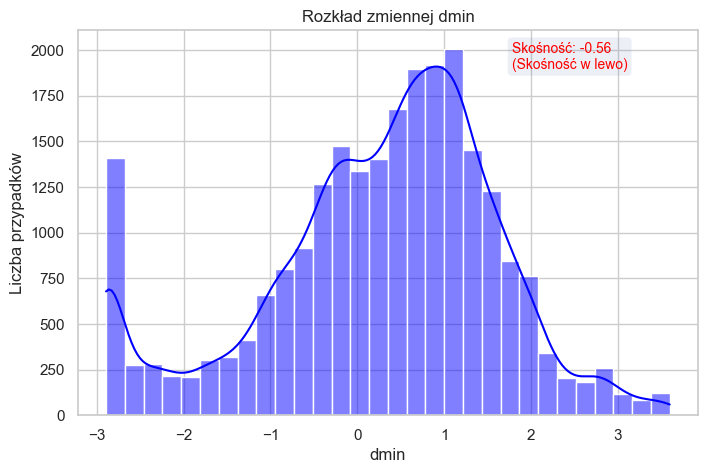

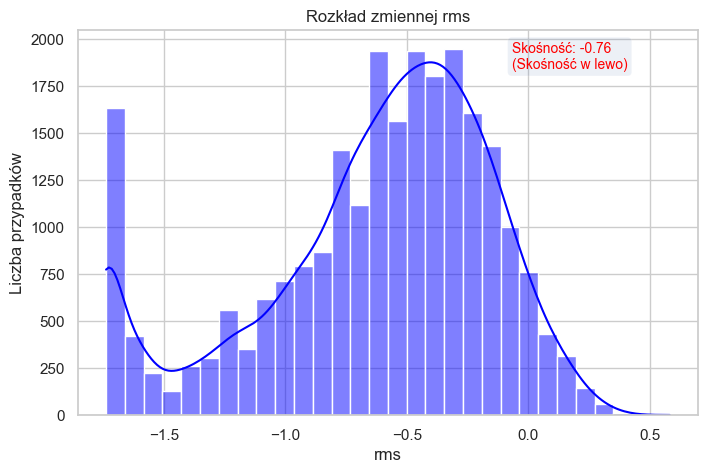

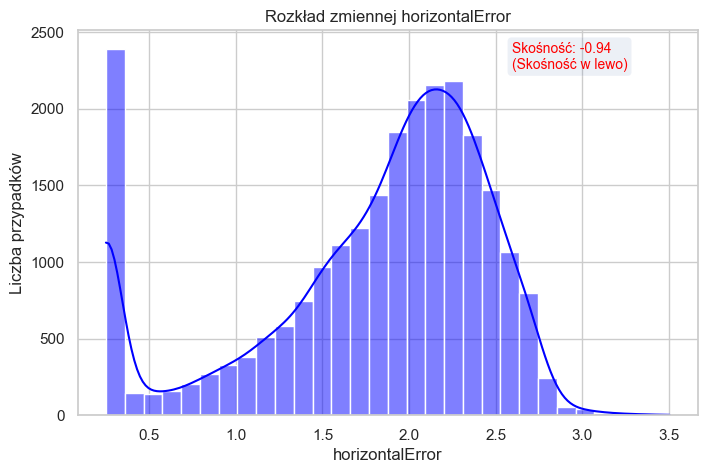

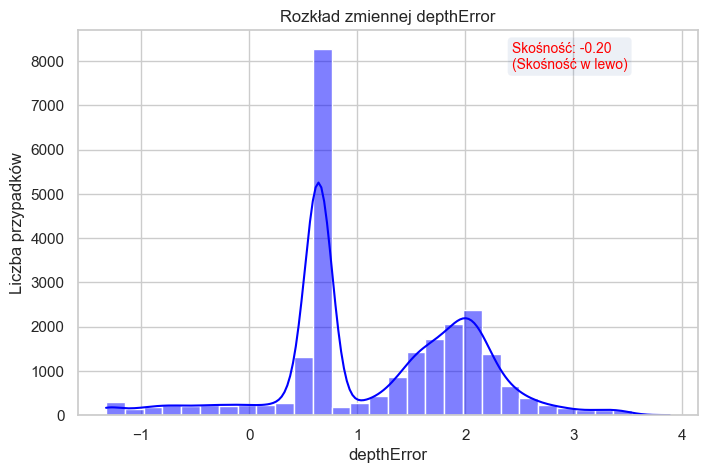

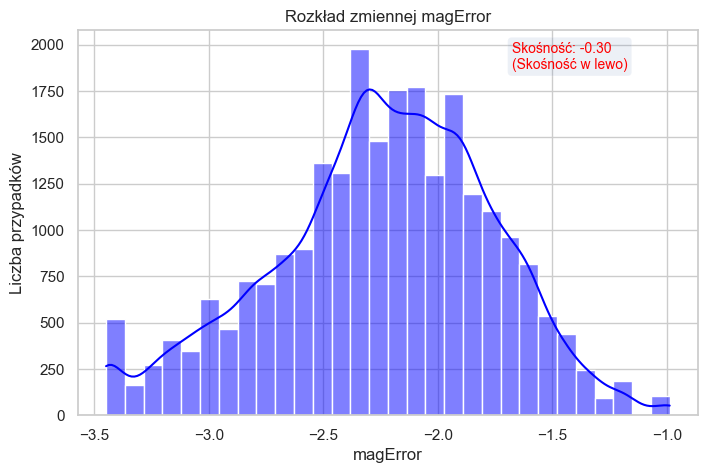

In [226]:
sns.set(style="whitegrid")

for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        plt.figure(figsize=(8, 5))
        sns.histplot(df[col], kde=True, color='blue', bins=30)
        plt.title(f'Rozkład zmiennej {col}')
        plt.xlabel(col)
        plt.ylabel('Liczba przypadków')

        skewness = df[col].skew()
        skew_label = "Skośność w prawo" if skewness > 0 else "Skośność w lewo" if skewness < 0 else "Brak skośności"
        plt.annotate(f"Skośność: {skewness:.2f}\n({skew_label})", 
                     xy=(0.7, 0.9), xycoords='axes fraction',
                     bbox=dict(boxstyle="round", alpha=0.1),
                     fontsize=10, color='red')

        plt.show()

#### Jak widzimy powyżej, większość próbek jest lewostronnie skośna. Najbardziej z nich jest próbka 'depth'